In [3]:
!pip install xgboost
!pip install tabulate
!pip install vaderSentiment

In [1]:
import xgboost
import warnings
import textblob

import numpy as np
import pandas as pd
import keras.utils as U
import keras.layers as L
import keras.models as M
import keras.optimizers as opt
import matplotlib.pyplot as plt

from utils import *
from doc_utils import *
from tabulate import tabulate
from sklearn.ensemble import *
from collections import Counter
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import RidgeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from nlp_utils import get_features, make_predictions
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import precision_score, recall_score, f1_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
plt.rcParams['figure.figsize'] = [20, 8]

# Read tweets csv
df = pd.read_json("../../data/TweetsConsolidated.json")

# Drop all-null rows if any
df.dropna(how='all', inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
lead_days = 2
days_window = 5

start_date = pd.to_datetime("23-feb-2019")
end_date = pd.to_datetime("13-apr-2019")


labels = process_acled_csv("../../data/1900-01-01-2019-04-15-India.csv", 
                           top_locations=-1, 
                           start=start_date, 
                           end=end_date,
                           lead_days=lead_days,
                           days_window = days_window)

Data from 2019-02-23 to 2019-04-13  & Number of days - 50


In [4]:
clean = False
if not clean:
    df = clean_df(df)
    clean = True

Dropping 1 rows!


In [5]:
df.head(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extracted_location,extractedlocation,favorite_count,favorited,...,userfollowers_count,userfollowing,userfriends_count,userlisted_count,userlocation,username,userscreen_name,userstatuses_count,userverified,withheld_in_countries
0,NaN,None,2019-03-05 04:05:13,"[26, 264]","{'hashtags': [{'text': 'Telangana', 'indices':...",None,"india, telangana",None,3,False,...,2175.0,NaN,1378.0,22.0,Hyderabad,Anusha Puppala,anusha_puppala,4178.0,0.0,None
1,NaN,None,2019-03-05 04:05:13,"[26, 264]","{'hashtags': [{'text': 'Telangana', 'indices':...",None,"india, telangana",None,3,False,...,2175.0,NaN,1378.0,22.0,Hyderabad,Anusha Puppala,anusha_puppala,4178.0,0.0,None
10,NaN,None,2019-03-04 18:23:13,"[0, 125]","{'hashtags': [], 'symbols': [], 'user_mentions...",None,west bengal,None,0,False,...,918.0,NaN,5000.0,177.0,Earth Sol 1 MilkyWay Laniakea,//bpUnKρRοtocol//,cw4t7abs,91316.0,0.0,None
100,NaN,None,2019-03-05 05:44:31,"[0, 276]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1102806036082176000, 'id_str...",west bengal,None,0,False,...,1106.0,NaN,2257.0,1.0,जालोर राजस्थान,Chowkidar Manohar Modi Aipura,manoharsolank82,3224.0,0.0,None
1000,NaN,None,2019-02-25 21:43:02,"[25, 270]","{'hashtags': [], 'symbols': [], 'user_mentions...",None,"haryana, india",None,0,False,...,3.0,NaN,43.0,0.0,Delhi,Bhart Vashist,BhartVashist,703.0,0.0,None


In [8]:
df.dropna(subset=['id'], inplace=True)
df = get_tweet_sentiment(df)

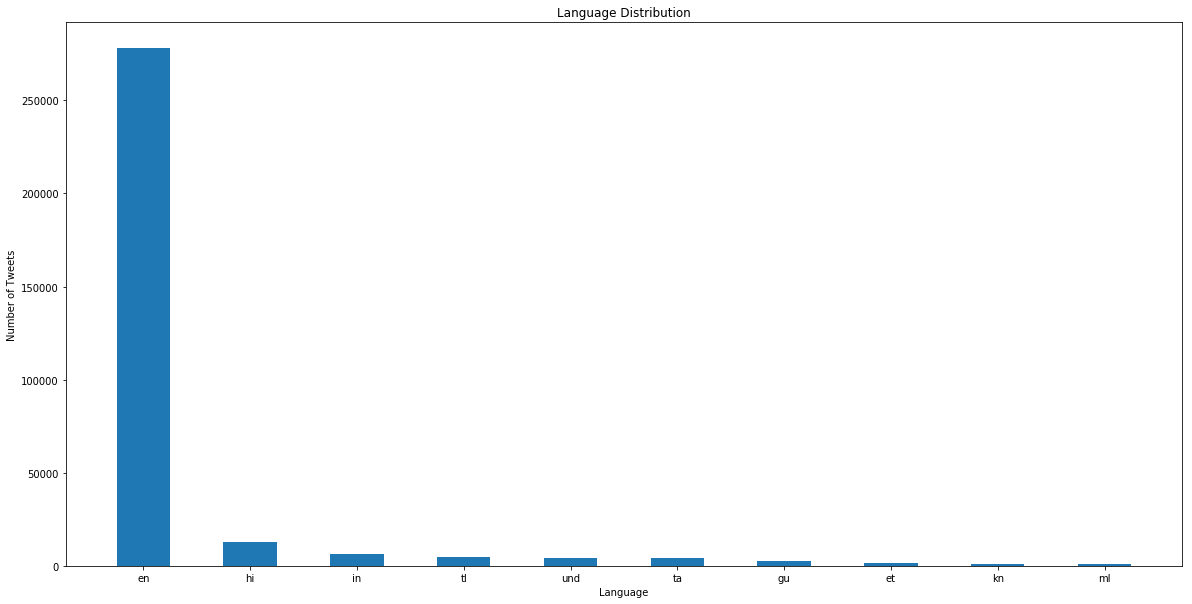

In [9]:
plot_counter(df['lang'], num_elements=10, xlabel="Language", ylabel="Number of Tweets", title="Language Distribution")

In [10]:
df

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extracted_location,extractedlocation,favorite_count,favorited,...,userlocation,username,userscreen_name,userstatuses_count,userverified,withheld_in_countries,neg,neu,pos,compound
0,NaN,None,2019-03-05 04:05:13,"[26, 264]","{'hashtags': [{'text': 'Telangana', 'indices':...",None,"india, telangana",None,3,False,...,Hyderabad,Anusha Puppala,anusha_puppala,4178.0,0.0,None,0.073,0.844,0.083,0.1154
1,NaN,None,2019-03-05 04:05:13,"[26, 264]","{'hashtags': [{'text': 'Telangana', 'indices':...",None,"india, telangana",None,3,False,...,Hyderabad,Anusha Puppala,anusha_puppala,4178.0,0.0,None,0.073,0.844,0.083,0.1154
10,NaN,None,2019-03-04 18:23:13,"[0, 125]","{'hashtags': [], 'symbols': [], 'user_mentions...",None,west bengal,None,0,False,...,Earth Sol 1 MilkyWay Laniakea,//bpUnKρRοtocol//,cw4t7abs,91316.0,0.0,None,0.101,0.745,0.154,0.2500
100,NaN,None,2019-03-05 05:44:31,"[0, 276]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1102806036082176000, 'id_str...",west bengal,None,0,False,...,जालोर राजस्थान,Chowkidar Manohar Modi Aipura,manoharsolank82,3224.0,0.0,None,0.000,1.000,0.000,0.0000
1000,NaN,None,2019-02-25 21:43:02,"[25, 270]","{'hashtags': [], 'symbols': [], 'user_mentions...",None,"haryana, india",None,0,False,...,Delhi,Bhart Vashist,BhartVashist,703.0,0.0,None,0.095,0.836,0.069,-0.0644
10000,NaN,None,2019-02-26 16:57:32,"[14, 176]","{'hashtags': [], 'symbols': [], 'user_mentions...",None,"haryana, punjab",None,2,False,...,None,🍪 ביסקוויט,bakened,12159.0,0.0,None,0.118,0.836,0.045,-0.4754
100000,NaN,None,2019-03-27 03:53:14,"[0, 82]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1110751603710152704, 'id_str...","tamil,india",,0,False,...,"Tanga, Tanzania",Wilson Jacob,wilsonjmashaka,39191.0,0.0,None,0.213,0.787,0.000,-0.4019
100001,NaN,None,2019-03-27 03:53:14,"[0, 82]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1110751603710152704, 'id_str...","tamil,india",,0,False,...,"Tanga, Tanzania",Wilson Jacob,wilsonjmashaka,39191.0,0.0,None,0.213,0.787,0.000,-0.4019
100002,NaN,None,2019-03-27 03:53:14,"[0, 82]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1110751603710152704, 'id_str...","tamil,india",,0,False,...,"Tanga, Tanzania",Wilson Jacob,wilsonjmashaka,39191.0,0.0,None,0.213,0.787,0.000,-0.4019
100003,NaN,None,2019-03-27 03:52:02,"[0, 82]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1110751304157200384, 'id_str...","tamil,india",,0,False,...,"Tanga, Tanzania",Wilson Jacob,wilsonjmashaka,39191.0,0.0,None,0.213,0.787,0.000,-0.4019


In [11]:
df['created_at'] = pd.to_datetime(df['created_at'])
# Sort by time created
df.sort_values(by=['created_at'], inplace=True)

In [12]:
print(start_date, end_date)

warnings.filterwarnings('ignore')
location_date_dict = interleave_location_and_date(df, start_date, end_date)
warnings.filterwarnings('default')

2019-02-23 00:00:00 2019-04-13 00:00:00


### Current Features
   * Number of tweets each day
   * Average pos, neg, neu and compound features
   * Tweet count with neg sentiment

### TODO
   * Hate speech
   * Violent speech

In [13]:
location_features_dict = {}
for location in location_date_dict:
    location_features_dict[location] = get_features(location_date_dict[location])
    print(location, "done")

Sangrur done
Jalandhar done
Amritsar done
Ludhiana done
Chandigarh done
Bathinda done
Patiala done
Bengaluru done
Delhi-New Delhi done
India done
Gurgaon done
Karnal done
Thiruvananthapuram done
Dehradun done
Lucknow done
Pulwama done
Hyderabad done
Kolkata done
Ahmedabad done
Guwahati done
Chennai done
Tiruchirappalli done
Madurai done
Coimbatore done
Salem done
Puducherry done
Imphal done
Agartala done
Jammu done
Ranchi done
Shimla done
Patna done
Jaipur done
Srinagar done
Bhubaneswar done
Bangkok done


In [28]:
make_predictions(location_features_dict, labels, permute=False)

|      Location      |   Train Accuracy |   Test Accuracy |   Precision |   Recall |   F1 Score |   +'s in data |
|:------------------:|-----------------:|----------------:|------------:|---------:|-----------:|--------------:|
|  Delhi-New Delhi   |             0.97 |            0.82 |        0.82 |     1    |       0.9  |          0.93 |
|       Jammu        |             1    |            0.82 |        0.82 |     1    |       0.9  |          0.95 |
|      Amritsar      |             1    |            0.73 |        0.73 |     1    |       0.84 |          0.93 |
|      Ludhiana      |             0.94 |            0.73 |        0.73 |     1    |       0.84 |          0.88 |
|      Srinagar      |             1    |            0.73 |        0.73 |     1    |       0.84 |          0.93 |
|     Bengaluru      |             0.97 |            0.64 |        0.64 |     1    |       0.78 |          0.81 |
|     Hyderabad      |             0.94 |            0.64 |        0.64 |     1    |    

In [20]:
def generate_LSTM_model(history):
    """ Generates a compiled LSTM model
    
    Input - Number of history points considered
    """
    model = M.Sequential()
    model.add(L.InputLayer(input_shape=(history, 6)))
    model.add(L.LSTM(10))
    model.add(L.Dense(20, activation='relu'))
    model.add(L.Dense(2))
    model.add(L.Softmax())
    
    model.compile(loss="categorical_crossentropy", optimizer=opt.Adam(0.01))
    return model

def generate_CNN_model(history):
    """ Generate a compiled 1D CNN model
    
    Input - Number of history points considered
    """
    model = M.Sequential()
    model.add(L.InputLayer(input_shape=(history, 6)))
    model.add(L.Conv1D(32, kernel_size=3))
    model.add(L.Conv1D(16, kernel_size=1))
    model.add(L.Flatten())
    model.add(L.Dense(20, activation='relu'))
    model.add(L.Dense(2))
    model.add(L.Softmax())

    model.compile(loss="categorical_crossentropy", optimizer=opt.Adam(0.01))
    return model

def make_deep_predictions(location_features_dict, labels, model=None, permute=False, lead_days=2, days_window=5, history=3):
    """
    Input - 
            location_features_dict - The dict mapping from location to features
            labels - Label dict generated from process_acled_csv(..)
            model - Specific sklearn model to evaluate/benchmark performance
            permute - Permute the data before train-test split
            history - The number of data points for contextualization
    Returns - None
    """
    # Table for presenting on tabulate
    result_table = []

    # Compute intersection for locations present on both dicts
    common_locations = set(location_features_dict.keys()) & set(labels.keys())

    # Sorted for clarity
    common_locations = sorted(list(common_locations))

    for common_location in common_locations:
        # Get data and labels
        X, y = location_features_dict[common_location], labels[common_location]
        X, y = np.array(X), np.array(y)

        # Eliminate last days to match labels.shape
        X = X[:-(lead_days + days_window)]
        
        # Generate data for LSTM/CNN
        # Basically, use points from i to i + history
        # and predict for i + history + 1
        temp_X, temp_y = [], []
        for i in range(len(X) - history - 1):
            temp_X.append(X[i: i + history])
            temp_y.append(y[i + history + 1])
        
        X, y = np.array(temp_X), np.array(temp_y)
        
        # Permute randomly if specified
        if permute:
            p = np.random.permutation(len(X))
            X, y = X[p], y[p]

        # Split data into train & test - 75% & 25%
        split = int(0.75 * len(X))
        
        xtrain, ytrain = X[:split], y[:split]
        xtest, ytest = X[split:], y[split:]
        
        
        model = generate_CNN_model(history)


        ytrain, ytest = U.to_categorical(ytrain, num_classes=2), U.to_categorical(ytest, num_classes=2)
        # Fit the train data
        model.fit(xtrain, ytrain, epochs=100, verbose=0)

        # Make predictions
        ypred = model.predict(xtest)
        ytrain_pred = model.predict(xtrain)

        # Uncategorize
        uncategorize = lambda x: np.argmax(x, axis=1)

        ytrain, ytest = uncategorize(ytrain), uncategorize(ytest)
        ytrain_pred, ypred = uncategorize(ytrain_pred), uncategorize(ypred)

        # Compute metrics
        train_acc = np.mean(ytrain_pred == ytrain)
        test_acc = np.mean(ytest == ypred)
        precision = precision_score(ytest, ypred, average='weighted', labels=np.unique(ypred))
        recall = recall_score(ytest, ypred, average='weighted', labels=np.unique(ypred))
        f1 = f1_score(ytest, ypred, average='weighted', labels=np.unique(ypred))

        # Add row to result_table
        result_row = [common_location,
                      np.round(train_acc, 2), np.round(test_acc, 2),
                      np.round(precision, 2), np.round(recall, 2),
                      np.round(f1, 2),
                      np.round(np.sum(y) / len(y), 2)]
        result_table.append(result_row)

    # Average stats
    # Turns out median is kind of useless
    result_table_copy = (np.array(result_table)[:, 1:]).astype(np.float32)
    result_table = sorted(result_table, key=lambda x: -x[2])
    averages = np.round(np.mean(result_table_copy, axis=0), 2)

    # Add them to the existing result table
    result_table.append(["Average"] + averages.tolist())

    # Header for table
    header = ["Location", "Train Accuracy", "Test Accuracy",
              "Precision", "Recall", "F1 Score", "+'s in data"]
    
    # Print tabulated result
    print(tabulate(result_table, 
                   tablefmt="pipe", 
                   stralign="center", 
                   headers=header))
    
    

In [21]:
make_deep_predictions(location_features_dict, labels, permute=False)

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


|      Location      |   Train Accuracy |   Test Accuracy |   Precision |   Recall |   F1 Score |   +'s in data |
|:------------------:|-----------------:|----------------:|------------:|---------:|-----------:|--------------:|
|       Ranchi       |             0.9  |            1    |        1    |      1   |       1    |          0.36 |
|       Shimla       |             0.83 |            1    |        1    |      1   |       1    |          0.26 |
|      Dehradun      |             1    |            0.9  |        1    |      0.9 |       0.95 |          0.21 |
|      Madurai       |             0.9  |            0.9  |        1    |      0.9 |       0.95 |          0.41 |
|  Tiruchirappalli   |             0.83 |            0.9  |        1    |      0.9 |       0.95 |          0.28 |
|  Delhi-New Delhi   |             0.97 |            0.8  |        0.8  |      1   |       0.89 |          0.92 |
|       Jammu        |             1    |            0.8  |        0.8  |      1   |    